<a href="https://colab.research.google.com/github/CaseCoding/Pfp-Matcher-Software/blob/main/Matching_Modelv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

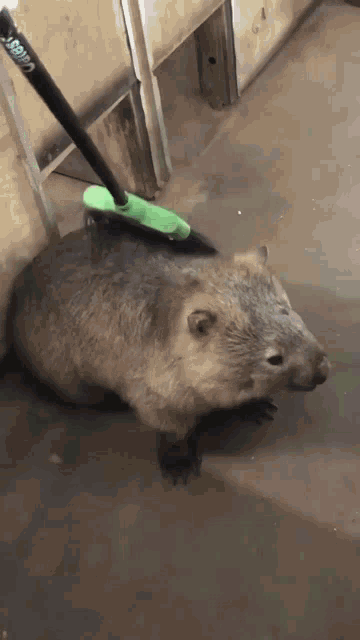

# Quick Model I set up to match and overlay images, can be refined to fit inside of the actual software itself.

Are you matching a profile picture against banners or a banner against profile pictures? (Enter 'pfp' or 'banner'): pfp
Please provide the path to the profile picture: /content/Profile_Pictures/testpfpblack.jpg
Please provide the path to the banners directory: /content/Banners
Which matching method do you prefer? (Enter 'color', 'feature', or 'both'): color

Best matches with scores:
/content/Banners/1200  X 480 INKSHADOW BASE Discord Banner.png: Score = 11.53/100
/content/Banners/4800 X 1920 CAAS AKALI Discord Banner.png: Score = 10.09/100
/content/Banners/4800 X 1920 BLEMISHINE Caas Discord Banner.png: Score = 9.84/100
/content/Banners/1200 X 480 MIRACLECAAS Base Discord Banner.png: Score = 9.54/100
/content/Banners/4800 X 1920 AOM KIRINO Discord Banner.png: Score = 8.56/100
/content/Banners/4800 X 1920 SARIELVA LATTE Discord Banner.png: Score = 7.65/100
/content/Banners/4800 X 1920 SARIELVA 2.0 VARIANT Discord Banner.png: Score = 7.21/100
/content/Banners/4800 X 1920 CAAS TWITCH VAR

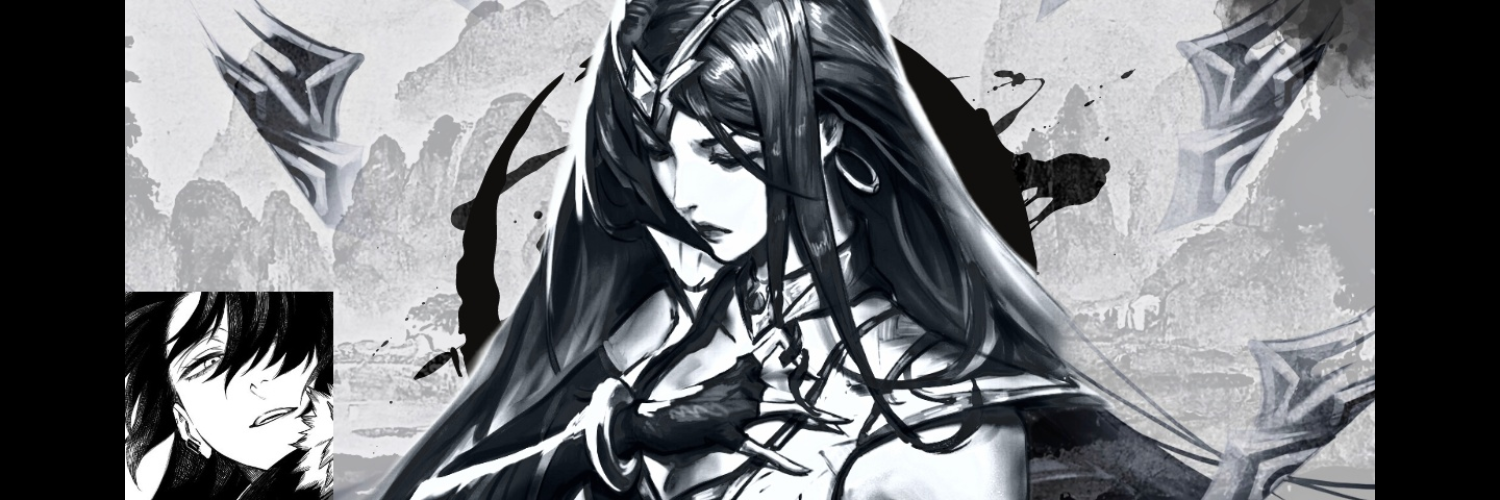

Saved overlay image: overlay_2.jpg
Overlay 2:


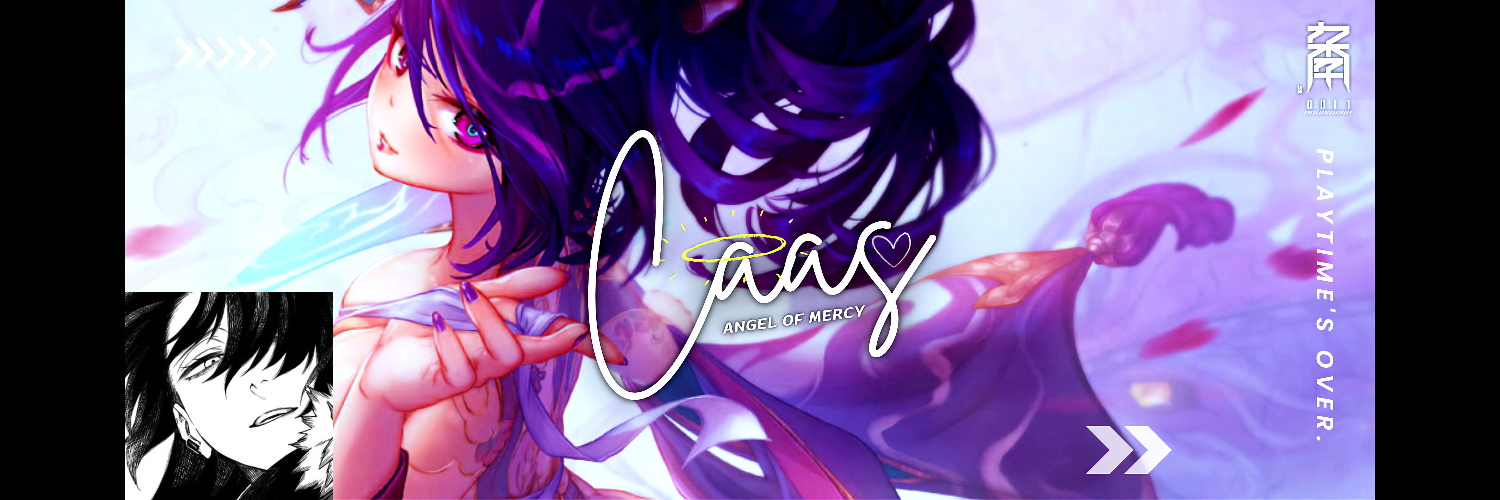

Saved overlay image: overlay_3.jpg
Overlay 3:


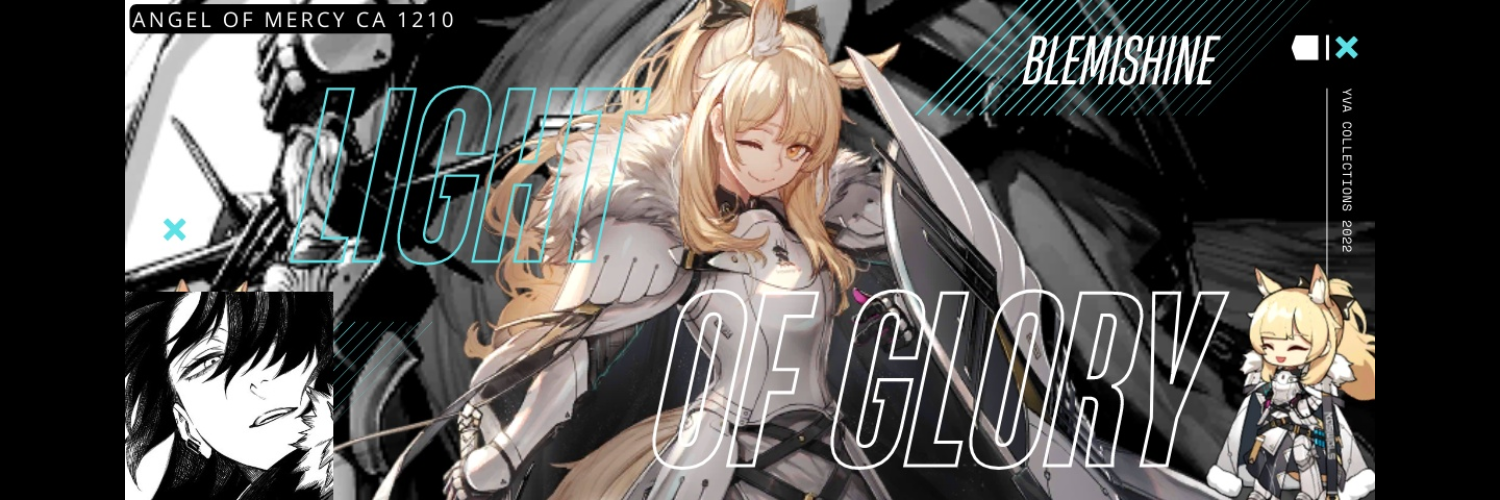

In [25]:
import cv2
import os
from google.colab.patches import cv2_imshow
import numpy as np

def calculate_histogram(image_path):
    """Calculate the histogram of an image."""
    image = cv2.imread(image_path, 0)  # read image in grayscale
    hist = cv2.calcHist([image], [0], None, [256], [0,256])
    cv2.normalize(hist, hist)
    return hist

def histogram_intersection(hist1, hist2):
    """Compute the histogram intersection between two histograms."""
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT)

def compute_feature_match_score(image1_path, image2_path):
    """Compute a matching score based on ORB feature matching."""
    img1 = cv2.imread(image1_path, 0)
    img2 = cv2.imread(image2_path, 0)
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    # Use the number of feature matches as the score
    return len(matches)

def best_fits(image_path, directory_path, mode, preference):
    """Determine best fitting images for an input image based on histogram and feature matching."""
    main_histogram = calculate_histogram(image_path)

    scores = {}
    for image_file in os.listdir(directory_path):
        other_image_path = os.path.join(directory_path, image_file)
        try:
            other_histogram = calculate_histogram(other_image_path)
            hist_score = histogram_intersection(main_histogram, other_histogram)
            if mode == 'pfp':
                feature_score = compute_feature_match_score(image_path, other_image_path)
            else:
                feature_score = compute_feature_match_score(other_image_path, image_path)

            # Normalize scores
            hist_score = hist_score / 2.55  # Scaled so max value is 100
            feature_score = feature_score / max(len(other_histogram), len(main_histogram)) * 100

            # Adjust scores based on preference
            if preference == 'color':
                combined_score = 0.8 * hist_score + 0.2 * feature_score
            elif preference == 'feature':
                combined_score = 0.2 * hist_score + 0.8 * feature_score
            else:  # 'both'
                combined_score = (hist_score + feature_score) / 2

            scores[other_image_path] = combined_score
        except Exception as e:
            print(f"Error processing {image_file}: {e}")

    sorted_matches = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
    return sorted_matches


def overlay_image_on_banner(pfp_path, banner_path, output_path):
    """Overlay the profile picture on the banner and save the result."""
    pfp = cv2.imread(pfp_path)
    banner = cv2.imread(banner_path)

    target_width = banner.shape[1] // 6
    scale_factor = target_width / pfp.shape[1]
    new_dims = (int(pfp.shape[1] * scale_factor), int(pfp.shape[0] * scale_factor))
    pfp = cv2.resize(pfp, new_dims)

    banner[banner.shape[0]-pfp.shape[0]:, :pfp.shape[1]] = pfp
    cv2.imwrite(output_path, banner)

def resize_image_to_dimensions(img, width, height):
    """Resize an image to specific dimensions while retaining its aspect ratio."""
    original_height, original_width = img.shape[:2]
    aspect_ratio = original_width / original_height

    new_width = width
    new_height = int(new_width / aspect_ratio)
    if new_height > height:
        new_height = height
        new_width = int(new_height * aspect_ratio)

    resized_img = cv2.resize(img, (new_width, new_height))
    target_img = np.zeros((height, width, 3), dtype=np.uint8)
    y_offset = (height - new_height) // 2
    x_offset = (width - new_width) // 2
    target_img[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = resized_img

    return target_img

def main():
    mode = input("Are you matching a profile picture against banners or a banner against profile pictures? (Enter 'pfp' or 'banner'): ").lower()

    if mode == 'pfp':
        image_path = input("Please provide the path to the profile picture: ")
        directory_path = input("Please provide the path to the banners directory: ")
    elif mode == 'banner':
        image_path = input("Please provide the path to the banner: ")
        directory_path = input("Please provide the path to the profile pictures directory: ")
    else:
        print("Invalid mode selected!")
        return

    preference = input("Which matching method do you prefer? (Enter 'color', 'feature', or 'both'): ").lower()

    # Ensure the preference is valid
    if preference not in ['color', 'feature', 'both']:
        print("Invalid preference selected!")
        return

    # Adjust best_fits to work in both directions and provide the preference
    sorted_matches = best_fits(image_path, directory_path, mode, preference)

    print("\nBest matches with scores:")
    for match, score in sorted_matches.items():
        print(f"{match}: Score = {score:.2f}/100")

    top_matches = list(sorted_matches.keys())[:3]
    for idx, matched_image in enumerate(top_matches, 1):
        output_path = f'overlay_{idx}.jpg'
        if mode == 'pfp':
            overlay_image_on_banner(image_path, matched_image, output_path)
        else:
            overlay_image_on_banner(matched_image, image_path, output_path)
        print(f"Saved overlay image: {output_path}")

        overlay = cv2.imread(output_path)
        resized_overlay = resize_image_to_dimensions(overlay, 1500, 500)
        print(f"Overlay {idx}:")
        cv2_imshow(resized_overlay)



if __name__ == "__main__":
    main()